In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading and inspection

In [2]:
df = pd.read_csv("data/train.csv")
df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:


# df = df.drop_duplicates()
# df.info()

# Missing values

In [4]:
def info_with_nones(df):
    """Displays info only for columns with missing values."""
    null_counts = df.isnull().sum()
    cols_with_nones = null_counts[null_counts > 0].index
    couter = 0
    if not cols_with_nones.empty:
        for col in cols_with_nones:
            couter = couter+1
            print(f"Column: {col}, Null: {df[col].isnull().sum()}, Dtype: {df[col].dtype}", end="\n")
    else:
        print("No columns with missing values found.")
    print(f'Number of columns with Nones={couter}')
info_with_nones(df)

Column: LotFrontage, Null: 259, Dtype: float64
Column: Alley, Null: 1369, Dtype: object
Column: MasVnrType, Null: 872, Dtype: object
Column: MasVnrArea, Null: 8, Dtype: float64
Column: BsmtQual, Null: 37, Dtype: object
Column: BsmtCond, Null: 37, Dtype: object
Column: BsmtExposure, Null: 38, Dtype: object
Column: BsmtFinType1, Null: 37, Dtype: object
Column: BsmtFinType2, Null: 38, Dtype: object
Column: Electrical, Null: 1, Dtype: object
Column: FireplaceQu, Null: 690, Dtype: object
Column: GarageType, Null: 81, Dtype: object
Column: GarageYrBlt, Null: 81, Dtype: float64
Column: GarageFinish, Null: 81, Dtype: object
Column: GarageQual, Null: 81, Dtype: object
Column: GarageCond, Null: 81, Dtype: object
Column: PoolQC, Null: 1453, Dtype: object
Column: Fence, Null: 1179, Dtype: object
Column: MiscFeature, Null: 1406, Dtype: object
Number of columns with Nones=19


For some of the features, none is an actual information:

In [ ]:
df['Alley']=df['Alley'].fillna("NoAlley")

df['PoolQC']=df['PoolQC'].fillna("NoPool")

df['MiscFeature']=df['MiscFeature'].fillna("NoFeature")

df['Fence']=df['Fence'].fillna("NoFence")

df['MasVnrType']=df['MasVnrType'].fillna("NoMasonry")

df['FireplaceQu']=df['FireplaceQu'].fillna("NoFirePlace")

df['BsmtQual']=df['BsmtQual'].fillna("NoBasement")
df['BsmtCond']=df['BsmtCond'].fillna("NoBasement")
df['BsmtExposure']=df['BsmtExposure'].fillna("NoBasement")
df['BsmtFinType1']=df['BsmtFinType1'].fillna("NoBasement")
df['BsmtFinType2']=df['BsmtFinType2'].fillna("NoBasement")

df['GarageType']=df['GarageType'].fillna("NoGarage")
df['GarageYrBlt']=df['GarageYrBlt'].fillna("NoGarage")
df['GarageFinish']=df['GarageFinish'].fillna("NoGarage")
df['GarageQual']=df['GarageQual'].fillna("NoGarage")
df['GarageCond']=df['GarageCond'].fillna("NoGarage")



Remaining features with nones:

In [6]:
info_with_nones(df)


Column: LotFrontage, Null: 259, Dtype: float64
Column: MasVnrArea, Null: 8, Dtype: float64
Column: Electrical, Null: 1, Dtype: object
Number of columns with Nones=3


From those the most problematic is LotFrontage, which may be a strong predictor. Checking if using mean is sufficient:

In [7]:
df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

std is quite high, std/mean~0.3. Also, since 259/1460 ~18% of values are missing it would greatly impact the distribution of the LotFrontage. We will use more sophisticated imputation method

In [8]:
def impute_column_knn_sklearn(df, column_name, k=5):
    """Imputes a column using sklearn's KNNImputer."""
    df_numeric = df.select_dtypes(include=np.number)
    imputer = KNNImputer(n_neighbors=k)
    df_imputed = imputer.fit_transform(df_numeric)
    df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns, index=df.index)
    df[column_name] = df_imputed[column_name]
    return df

def evaluate_imputer_cross_validation_rmse(df, column_name, k_values, n_splits=5, random_state=42, mask_fraction=0.2):
    """
    Evaluates KNN imputer generalization using k-fold cross-validation and RMSE.
    A fraction of the known values in the target column is masked to simulate missingness.
    
    Parameters:
      df (DataFrame): The input DataFrame.
      column_name (str): The target column to impute.
      k_values (list): List of neighbor counts to test.
      n_splits (int): Number of cross-validation folds.
      random_state (int): Seed for reproducibility.
      mask_fraction (float): Fraction of non-missing values to mask in each test fold.
    
    Returns:
      dict: Average RMSE for each k value.
    """
    results = {}
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    numeric_df = df.select_dtypes(include=np.number)

    for k in k_values:
        rmse_values = []
        for train_index, test_index in kf.split(numeric_df):
            train_numeric = numeric_df.iloc[train_index]
            test_numeric = numeric_df.iloc[test_index].copy()  # Copy to avoid altering the original data

            # Identify non-missing entries in the target column of the test set
            non_missing = test_numeric[test_numeric[column_name].notna()]

            # Randomly mask a fraction of these non-missing values
            mask_indices = non_missing[column_name].sample(frac=mask_fraction, random_state=random_state).index
            
            # Save the true values for later comparison and mask the values
            true_values = test_numeric.loc[mask_indices, column_name].copy()
            test_numeric.loc[mask_indices, column_name] = np.nan
            
            # Fit the imputer on the training data and transform the test data
            imputer = KNNImputer(n_neighbors=k)
            imputer.fit(train_numeric)
            test_imputed = imputer.transform(test_numeric)
            test_imputed_df = pd.DataFrame(test_imputed, columns=test_numeric.columns, index=test_numeric.index)
            
            # Compute RMSE for the masked values only
            imputed_values = test_imputed_df.loc[mask_indices, column_name]
            rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
            rmse_values.append(rmse)
        
        results[k] = np.mean(rmse_values)
    
    return results

    


k_values = [3, 4, 5, 7, 9, 12, 15, 20, 25, 30]
results = evaluate_imputer_cross_validation_rmse(df, 'LotFrontage', k_values, mask_fraction=0.2)

for k, rmse in results.items():
    print(f"k = {k}: Average RMSE (Cross-Validation) = {rmse}")

best_k = min(results, key=results.get)
print(f"The best k value (based on average RMSE) is: {best_k}")


k = 3: Average RMSE (Cross-Validation) = 21.550955127743798
k = 4: Average RMSE (Cross-Validation) = 21.183260859590014
k = 5: Average RMSE (Cross-Validation) = 21.41815540611111
k = 7: Average RMSE (Cross-Validation) = 21.3202015471425
k = 9: Average RMSE (Cross-Validation) = 21.175464944636502
k = 12: Average RMSE (Cross-Validation) = 21.097739968200088
k = 15: Average RMSE (Cross-Validation) = 21.041156369228144
k = 20: Average RMSE (Cross-Validation) = 21.454750895145974
k = 25: Average RMSE (Cross-Validation) = 21.995924889852386
k = 30: Average RMSE (Cross-Validation) = 22.20306186783294
The best k value (based on average RMSE) is: 15


In [9]:
def impute_column_mean(df, column_name):
    """Imputes a column using the mean."""
    mean_value = df[column_name].mean()
    df[column_name] = df[column_name].fillna(mean_value)
    return df


def compare_imputation_distributions(df_original, df_mean, df_knn, column_name):
    """Compares the distributions of a column after different imputations with seaborn."""
    

    
    plt.figure(figsize=(12, 6))
    
    # First subplot - original data
    ax1 = plt.subplot(1, 3, 1)
    # Get the original non-missing data as a Series
    original_data = df_original[column_name].dropna()
    
    if len(original_data) > 0:
        # Explicitly convert to a pandas Series with a known valid color
        sns.histplot(original_data.reset_index(drop=True), kde=True, ax=ax1, color='blue')
        ax1.set_title(f'Original {column_name}\n(non-missing values)')
    else:
        ax1.text(0.5, 0.5, "No non-missing values", ha='center', va='center')
        ax1.set_title(f'Original {column_name}')

    # Second subplot - mean imputation
    ax2 = plt.subplot(1, 3, 2)
    # Ensure the data is a pandas Series
    mean_data = df_mean[column_name].reset_index(drop=True)
    sns.histplot(mean_data, kde=True, ax=ax2, color='green')
    ax2.set_title(f'Mean Imputation\n{column_name}')

    # Third subplot - KNN imputation
    ax3 = plt.subplot(1, 3, 3)
    # Ensure the data is a pandas Series
    knn_data = df_knn[column_name].reset_index(drop=True)
    sns.histplot(knn_data, kde=True, ax=ax3, color='red')
    ax3.set_title(f'KNN Imputation\n{column_name}')

    plt.tight_layout()
    plt.show()
    
    
    if len(original_data) > 0:
        print("\nOriginal data stats (non-missing):")
        print(f"Min: {original_data.min():.2f}, Max: {original_data.max():.2f}, Mean: {original_data.mean():.2f}")
    
    print("\nMean imputed stats:")
    print(f"Min: {mean_data.min():.2f}, Max: {mean_data.max():.2f}, Mean: {mean_data.mean():.2f}")
    
    print("\nKNN imputed stats:")
    print(f"Min: {knn_data.min():.2f}, Max: {knn_data.max():.2f}, Mean: {knn_data.mean():.2f}")



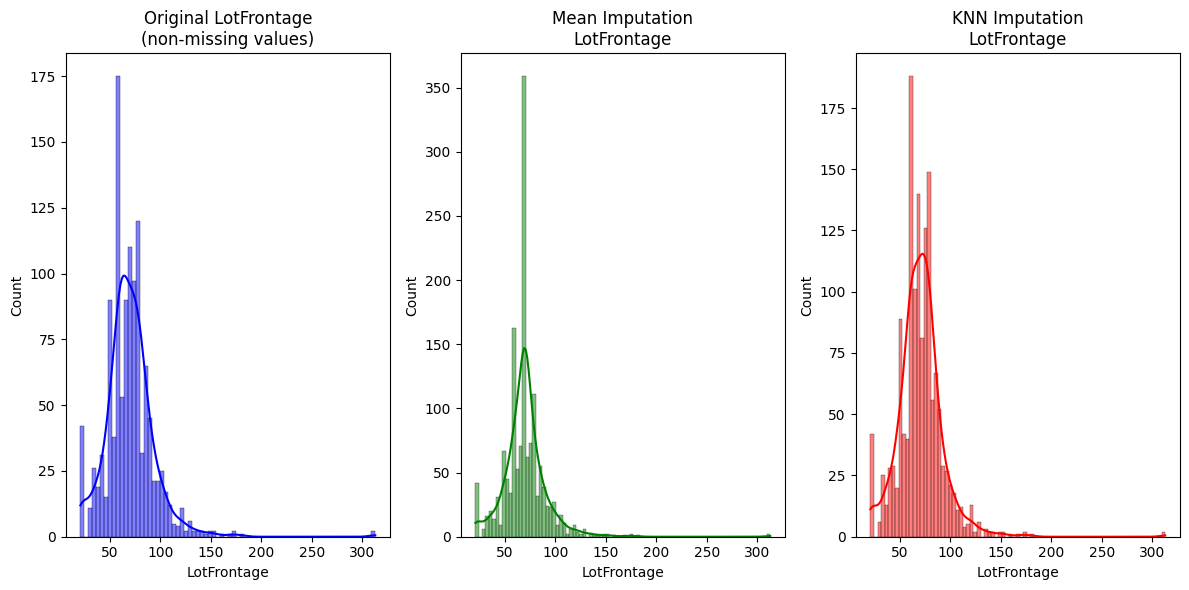


Original data stats (non-missing):
Min: 21.00, Max: 313.00, Mean: 70.05

Mean imputed stats:
Min: 21.00, Max: 313.00, Mean: 70.05

KNN imputed stats:
Min: 21.00, Max: 313.00, Mean: 70.63


In [10]:
df_mean_imputed = impute_column_mean(df.copy(), 'LotFrontage')
df_knn_sklearn_imputed = impute_column_knn_sklearn(df.copy(), 'LotFrontage', k=15)

compare_imputation_distributions(df, df_mean_imputed, df_knn_sklearn_imputed, 'LotFrontage')



Above everything looks right: the distribution after imputation looks similar to original one, certainly better than mean imputation

In [11]:
df_knn_sklearn_imputed = impute_column_knn_sklearn(df.copy(), 'LotFrontage', k=best_k)
info_with_nones(df_knn_sklearn_imputed)

Column: MasVnrArea, Null: 8, Dtype: float64
Column: Electrical, Null: 1, Dtype: object
Number of columns with Nones=2


Since only 8 values are missing in MasVnrArea

In [12]:
print(df_knn_sklearn_imputed['MasVnrArea'].describe(), '\n',"the median is", df['MasVnrArea'].median())

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64 
 the median is 0.0


In [13]:
def impute_column_median(df, column_name):
    """Imputes a column using the median."""
    median_value = df[column_name].median()
    df[column_name] = df[column_name].fillna(median_value)
    return df

def impute_column_top(df, column_name):
    """Imputes a column using the most common."""
    top_category = df[column_name].value_counts().idxmax()
    df[column_name] = df[column_name].fillna(top_category)
    return df

df_knn_sklearn_imputed = impute_column_median(df_knn_sklearn_imputed.copy(),'MasVnrArea')
df_knn_sklearn_imputed = impute_column_top(df_knn_sklearn_imputed.copy(),'Electrical')

In [14]:
info_with_nones(df_knn_sklearn_imputed)

No columns with missing values found.
Number of columns with Nones=0


In [15]:
df_knn_sklearn_imputed.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Dropping Id which is not a predictor

In [16]:
df_cleaned = df_knn_sklearn_imputed.drop(columns=['Id'])

In [17]:
info_with_nones(df_cleaned)


No columns with missing values found.
Number of columns with Nones=0


In [18]:
df_cleaned.to_csv('data/train_cleaned.csv', index=False)